<a href="https://colab.research.google.com/github/vargamartonaron/nma_23_rnn/blob/main/Copy_of_RNN_working_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim

In [2]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [3]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [4]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

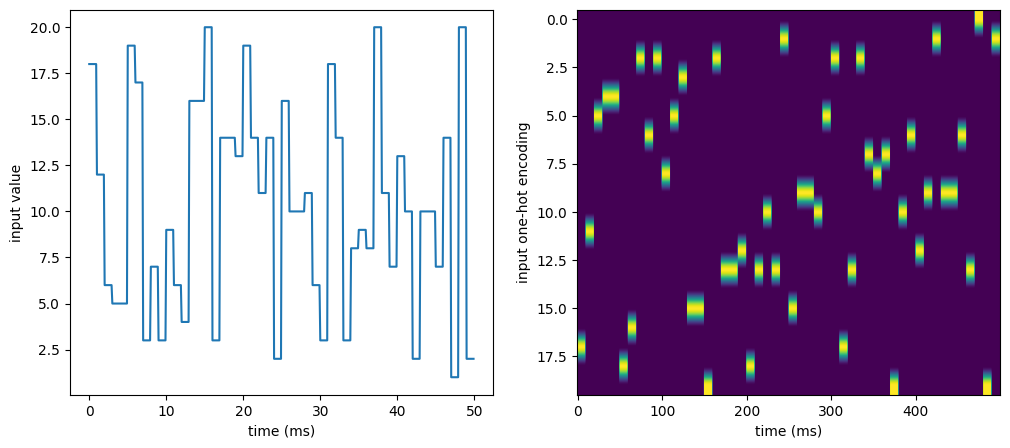

In [5]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

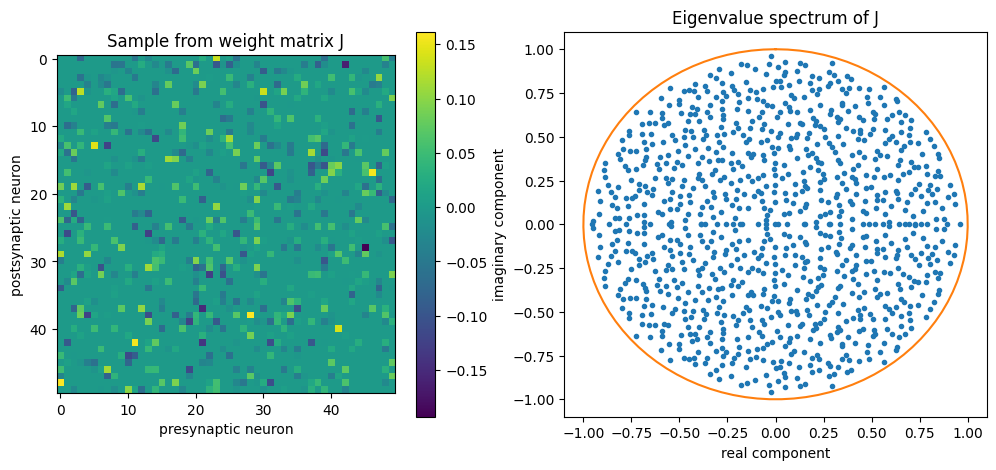

In [6]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

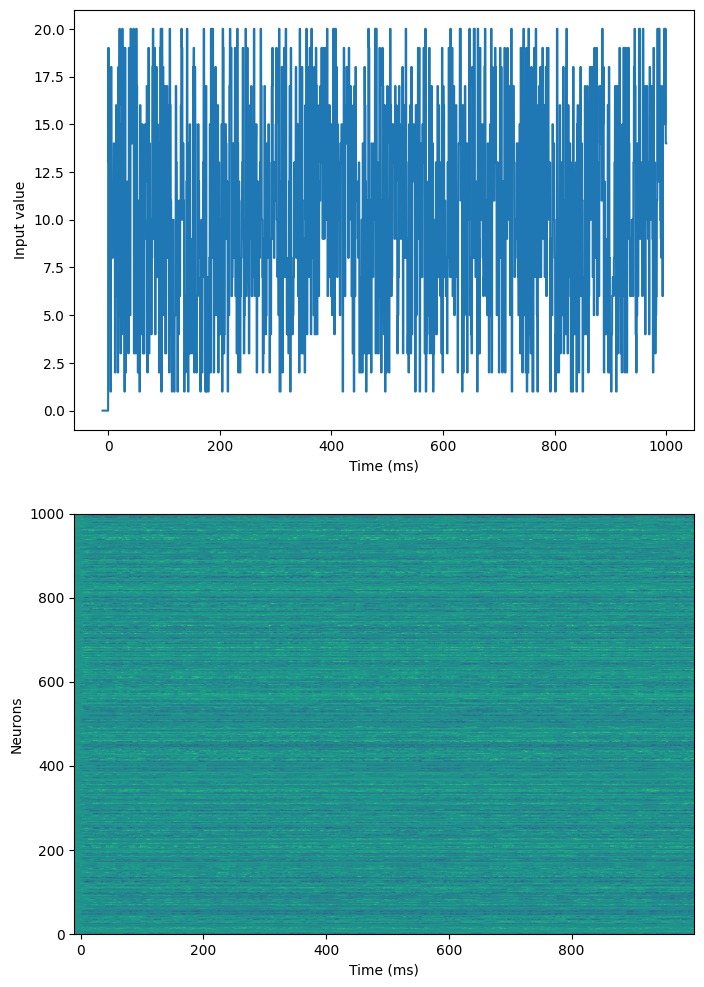

In [7]:
# Simulate the model activity.

# generate the input to the model
n_stimuli = 1000
onehot, input_stream = make_input(n_stimuli, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

In [8]:
# Make data to analyze
burnIn_steps = int(model['burnIn']/model['dt'])
durIn_steps =int(model['durIn']/model['dt'])

stimuli = np.arange(1, model['nIn']+1)
resp_0 = np.zeros((model['nIn']+1, model['N']))

# For each neuron avarage over its activity at the last step of durIn
# of inputs of each of 20 inputs
for i in range(1, model['nIn']+1):
  # Take only the index of the last timestep of each input period
  this_input_idx = np.where(input_stream == i)[0][durIn_steps-1::durIn_steps]
  resp_0[i] = np.mean(firing_rates[:,this_input_idx], 1)

# For each neuron z-score over all 20 inputs
resp_0 = stats.zscore(resp_0[1:], axis=0, nan_policy='omit')

In [9]:
resp_tensor = torch.tensor(resp_0, dtype=torch.float32)
stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

In [10]:
# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

n_stimuli = len(stimuli)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_tensor[itest]
resp_test = resp_tensor[itest]
stimuli_train = stimuli_tensor[itrain]
resp_train = resp_tensor[itrain]

In [11]:
class DeepNetReLU(nn.Module):
  """ network with a single hidden layer h with a RELU """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    h = torch.relu(self.in_layer(r)) # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)

    return y

In [12]:
def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()

iteration 100/500 | loss: 54.318
iteration 200/500 | loss: 1.433
iteration 300/500 | loss: 0.074
iteration 400/500 | loss: 0.015
iteration 500/500 | loss: 0.005


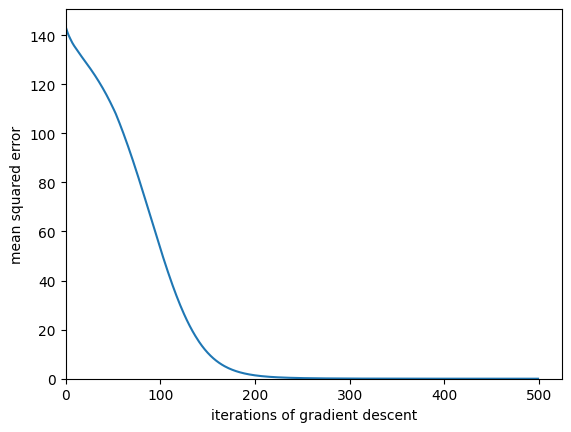

In [13]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=500, learning_rate=1e-4):

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(1000, 10)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)

Now: can you decode the model's input history from its firing rates?